In [1]:
%load_ext autoreload
%autoreload 2

import torch
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from time import time
from tqdm import tqdm
from collections import defaultdict
from math import ceil
import seaborn as sns

from approxmh.distributions import Banana, Funnel, create_gaussian_lattice, create_random_gaussian_mixture
from approxmh.distribution_metrics import *
from approxmh.utilities import *
from approxmh.y_utils import *
from approxmh.vae import VAE, VAETrainer, get_filename
from approxmh.samplers import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

2024-08-13 15:00:01.210888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 15:00:01.221768: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 15:00:01.224959: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 15:00:02.270777: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


device: cpu


**Target 1**

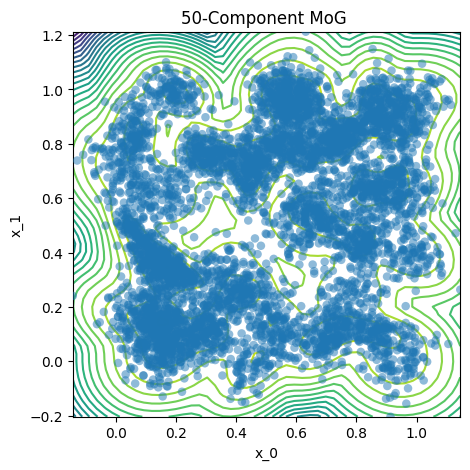

In [2]:
target_type = 1

if target_type == 0:  # Lattice
    target = create_gaussian_lattice(shape=(5, 5), variance=0.01, device=device)
elif target_type == 1:  # MoG
    target = create_random_gaussian_mixture(
        dim=2, n_components=50, mean_lim=(0, 1), 
        variance_lim=(0.0005, 0.005), seed=46, device=device
    )
elif target_type == 2:  # Funnel
    target = Funnel(dim=128, a=2, device=device)

visualize_distribution(target, levels=30, dpi=50, sample_size=6000)

In [3]:
hidden_dims = (64, 64, 64, 64)
model = VAE(
    data_dim=target.dim,
    hidden_dims=hidden_dims,
    latent_dim=target.dim,
    device=device
)
model_filename = Path(MODEL_DIR, f'{target.name}_hdim{hidden_dims}_vae')

TRAIN_VAE=False

In [4]:
if TRAIN_VAE:
    x_train = target.sample((16_384,))
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=500)
    trainer = VAETrainer(model, target, batch_size=2048, no_kl_penalty_epochs=10, kl_annealing_epochs=100, optimizer=optimizer, scheduler=scheduler, device=device)
    trainer.fit(x_train, n_epochs=1000, plot_interval=50)
    model.save_knowledge(model_filename)
else:
    model.load_knowledge(model_filename)

In [5]:
L = 512
beta = 1
model_log_prob_estimator = lambda x : model.iw_log_marginal_estimate(x, L=L, beta=beta, batch_L=32, return_variance=False)
dummy_estimator = lambda x: torch.ones(x.shape[0])

def get_density_ratios(samples):
    return target.log_prob(samples) - model_log_prob_estimator(samples)

CPU times: user 15.3 s, sys: 26.4 ms, total: 15.3 s
Wall time: 1.94 s


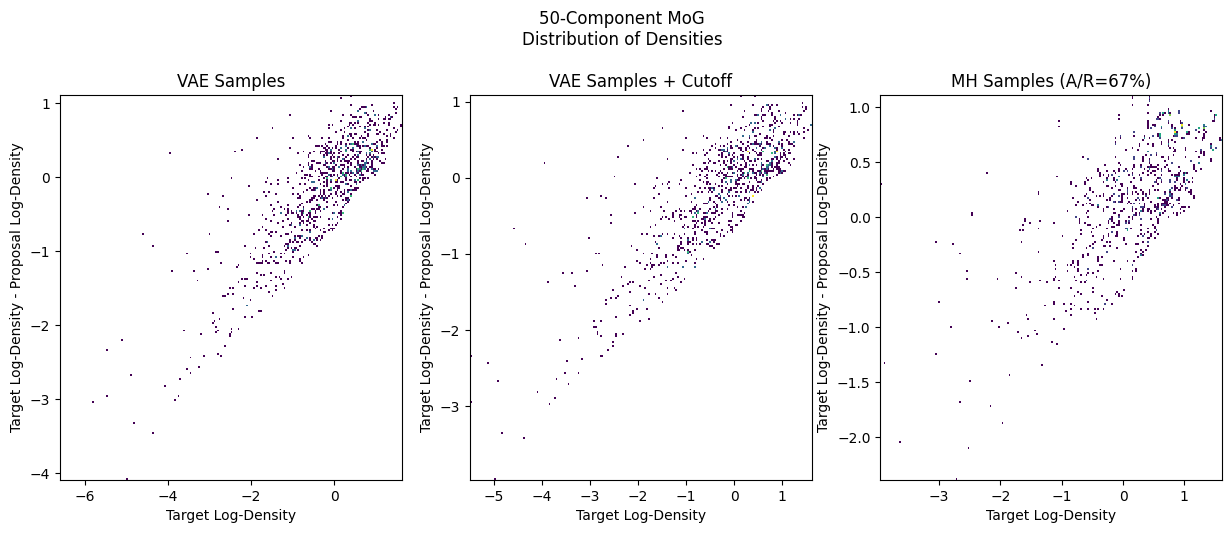

In [45]:
%%time

def plot_densities_distributions():
    N = 1_000
    q = 0.0
    target_samples = target.sample((N,))
    target_quantile = target.log_prob(target_samples).quantile(q)
    model_samples = model.sample((N,))
    
    dr_q = 0.005
    model_density_ratios = get_density_ratios(model_samples)
    #max_density_ratio = model_density_ratios.quantile(1 - dr_q)
    #dr_cutoff = 5
    max_density_ratio = 100
    model_samples = model_samples[model_density_ratios < max_density_ratio]

    cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, model_samples, target_quantile, return_indicies=False)
    mh_acc_rate, mh_samples = metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator, n_estimates=10)

    plot_info = [
        ('VAE Samples', model_samples),
        ('VAE Samples + Cutoff', cut_samples),
        (f'MH Samples (A/R={100*mh_acc_rate:0.0f}%)', mh_samples)
    ]
    
    fig, axs = plt.subplots(figsize=(15, 5), ncols=len(plot_info))
    #plt.tight_layout()
    #ax.set_xlim(left=ll_cutoff, right=torch.cat((mh_density_ratios, cut_density_ratios, model_density_ratios)).max().item()+1)
    
    ll_cutoff = -100
    for ax, (sample_name, samples) in zip(axs, plot_info):
        samples = samples[target.log_prob(samples) > ll_cutoff]
        ml_estimates = model_log_prob_estimator(samples)
        target_likelihoods = target.log_prob(samples)
        ax.hist2d(
            to_numpy(target_likelihoods),
            to_numpy(target_likelihoods - ml_estimates),
            bins=200,
            density=False,
            cmin=1,
        )
        filter_line_xs = np.array([5, 25])
        ax.plot(filter_line_xs, filter_line_xs - max_density_ratio, color='red', linewidth=1)
        ax.set_xlabel('Target Log-Density')
        ax.set_ylabel('Target Log-Density - Proposal Log-Density')
        ax.set_title(sample_name)
        # ax.set_aspect('equal')

    fig.suptitle(f'{target_friendly_name}\nDistribution of Densities', y=1.05)

plot_densities_distributions()

3it [00:00,  4.72it/s]

MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)
MH discarded 0 outlier(s)


4it [01:36, 38.03s/it]

MH discarded 0 outlier(s)


6it [01:38, 16.44s/it]


CPU times: user 11min 17s, sys: 1min 35s, total: 12min 52s
Wall time: 1min 38s


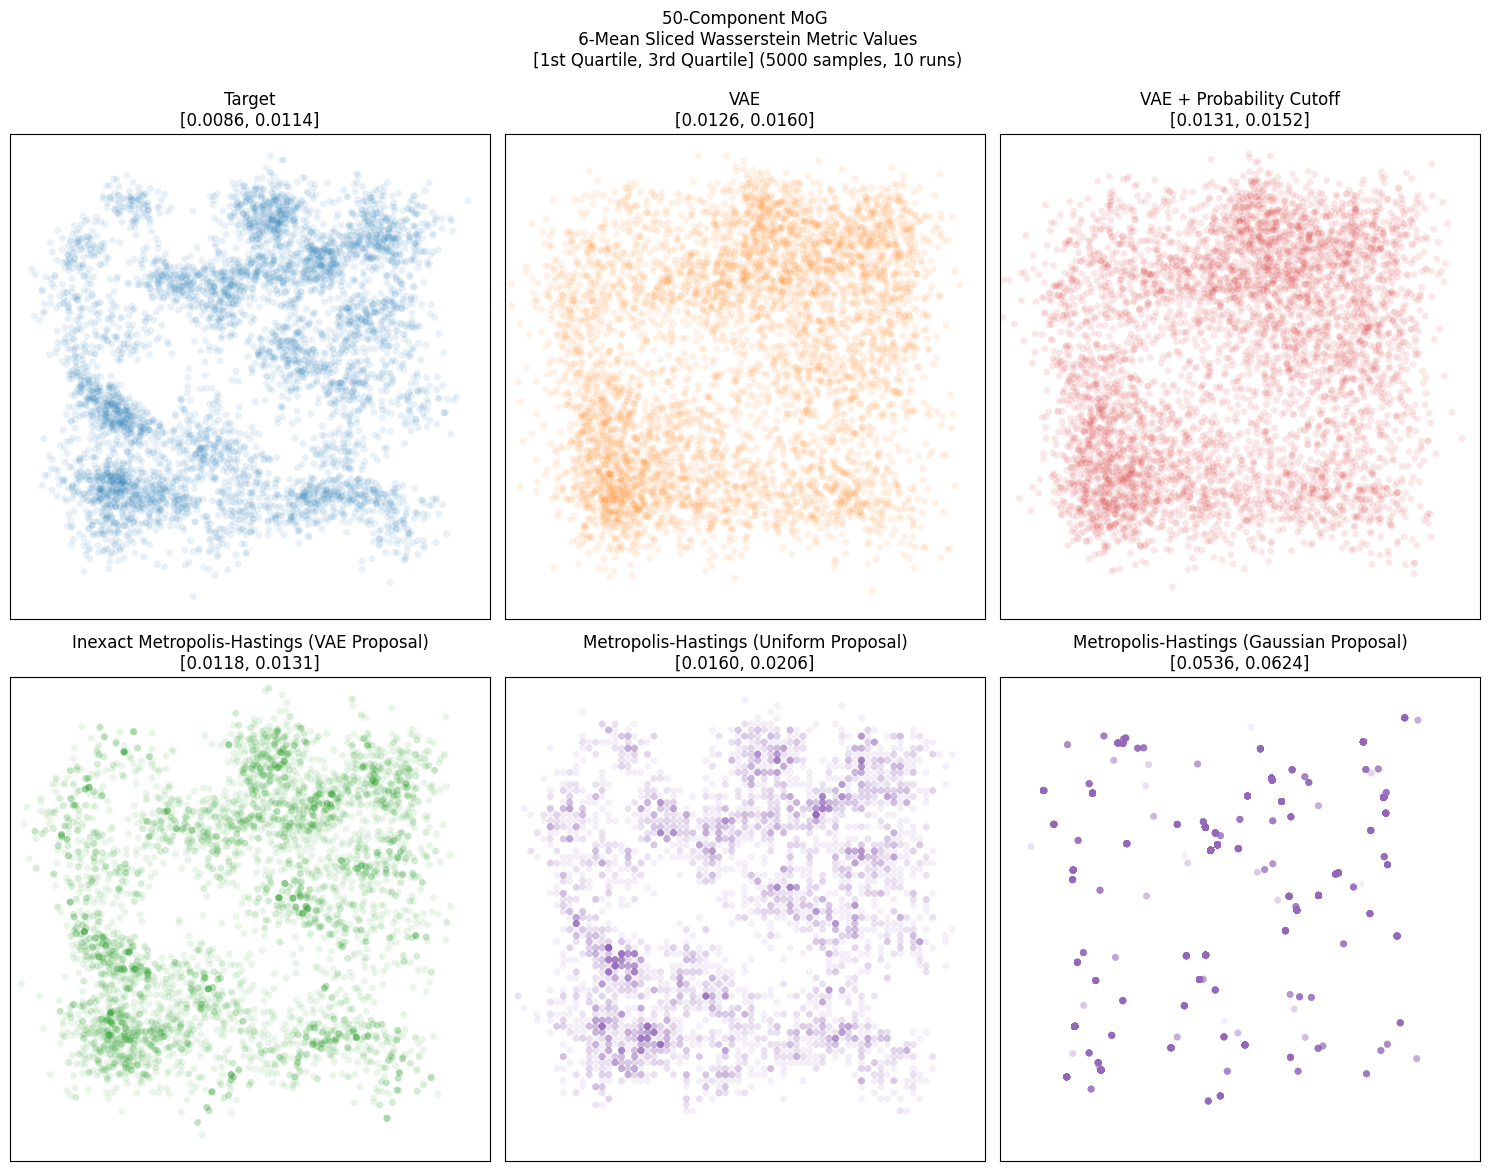

In [50]:
%%time

def plot_samples():
    metric = SlicedDistributionMetric(WassersteinMetric1d(), 3 * D)
    #metric = TotalVariation1d()
    # metric = WassersteinMetric()
    N = 5000
    q = 0
    n_runs = 10
    max_rejections=None
    n_estimates = 10
    
    target_samples = target.sample((N,))
    target_quantile = target.log_prob(target_samples).quantile(q)
    # model_samples = model.sample((N,))

    dr_q = 0.015
    # model_density_ratios = get_density_ratios(model_samples)
    #max_density_ratio = model_density_ratios.quantile(1 - dr_q)
    max_density_ratio = 1.5

    def evaluate_sample(get_sample):
        transform = lambda x: x
        # transform = lambda x: x[..., 0]  # Main axis projections
        return metric(transform(target.sample((N,))), transform(get_sample()))

    # Wrapped in a functions to allow multiple runs
    def get_cut_samples():
        return log_prob_cutoff_filter(target, model.sample((N,)), target_quantile, return_indicies=False)[1]
    def get_mh_samples():
        cut_samples = get_cut_samples()
        # cut_density_ratios = get_density_ratios(cut_samples)
        # cut_samples = cut_samples[cut_density_ratios < max_density_ratio]
        return metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator, n_estimates=n_estimates, max_density_ratio=max_density_ratio)[1]
    def get_uni_mh_samples():
        return metropolis_hastings_filter(target, uniform_samples, dummy_estimator)[1]
    def get_gaussian_mh_samples():
        # torch.diag(torch.tensor([3, 1], device=device))
        cov = torch.eye(2, device=device)
        cov[0][0] = 3
        cov[1][1] = 5
        gaussian_prop = torch.distributions.MultivariateNormal(torch.zeros(2, device=device), cov)
        return metropolis_hastings_filter(target, gaussian_prop.sample((N,)), gaussian_prop.log_prob)[1]

    plot_info = [
        (lambda: target.sample((N,)), 'Target', 'tab:blue'),
        (lambda: model.sample((N,)), 'VAE', 'tab:orange'),
        (get_cut_samples, 'VAE + Probability Cutoff', 'tab:red'),
        (get_mh_samples, 
         f'Inexact Metropolis-Hastings (VAE Proposal)', 
         'tab:green'),
    ]
    if D == 2:
        cmin = target_samples.min(dim=0)[0]
        cmax = target_samples.max(dim=0)[0]
        clims = [(cmin[0], cmax[0]), (cmin[1], cmax[1])]
        coord_values = [torch.linspace(*clim, ceil(N ** 0.5)) for clim in clims]
        grid_coords = torch.meshgrid(*coord_values, indexing='ij')
        uniform_samples = torch.vstack(tuple(map(torch.ravel, grid_coords))).T[torch.randperm(N)].to(device)
        plot_info.append((get_uni_mh_samples, 'Metropolis-Hastings (Uniform Proposal)', 'tab:purple'))
        plot_info.append((get_gaussian_mh_samples, 'Metropolis-Hastings (Gaussian Proposal)', 'tab:purple'))
        proj_vecs = torch.eye(2, device=device)
    else:
        proj_vecs = torch.qr(torch.randn(D, D, device=device, generator=torch.Generator(42))).Q[:2]
        proj_vecs = torch.zeros(2, D, device=device)
        proj_vecs[0][0] = 1
        proj_vecs[1][1] = 1
    
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 11))
    axs = axs.flatten()
    for i, (get_sample, sample_name, color) in tqdm(enumerate(plot_info)):
        #metric_mean, metric_std = estimate_mean_and_std(lambda: metric(target.sample((N,)), get_samples()), n_runs=10)
        metric_lower, metric_upper = estimate_quartiles(lambda: evaluate_sample(get_sample), n_runs=n_runs)
        axs[i].scatter(*pl(get_sample() @ proj_vecs.T), s=100, alpha=0.1, edgecolors='none', marker='.', c=color)
        axs[i].set_title(f'{sample_name}\n[{metric_lower:0.4f}, {metric_upper:0.4f}]')
    for ax in axs:
        #ax.axis('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(axs[0].get_xlim())
        ax.set_ylim(axs[0].get_ylim())
    plt.tight_layout()
    # Mean ± Std Dev
    fig.suptitle(f'{target_friendly_name}\n {metric.name()} Values\n [1st Quartile, 3rd Quartile] ({N} samples, {n_runs} runs)', y=1.06)

plot_samples()

MH discarded 0 outlier(s)


4it [00:00, 1042.97it/s]


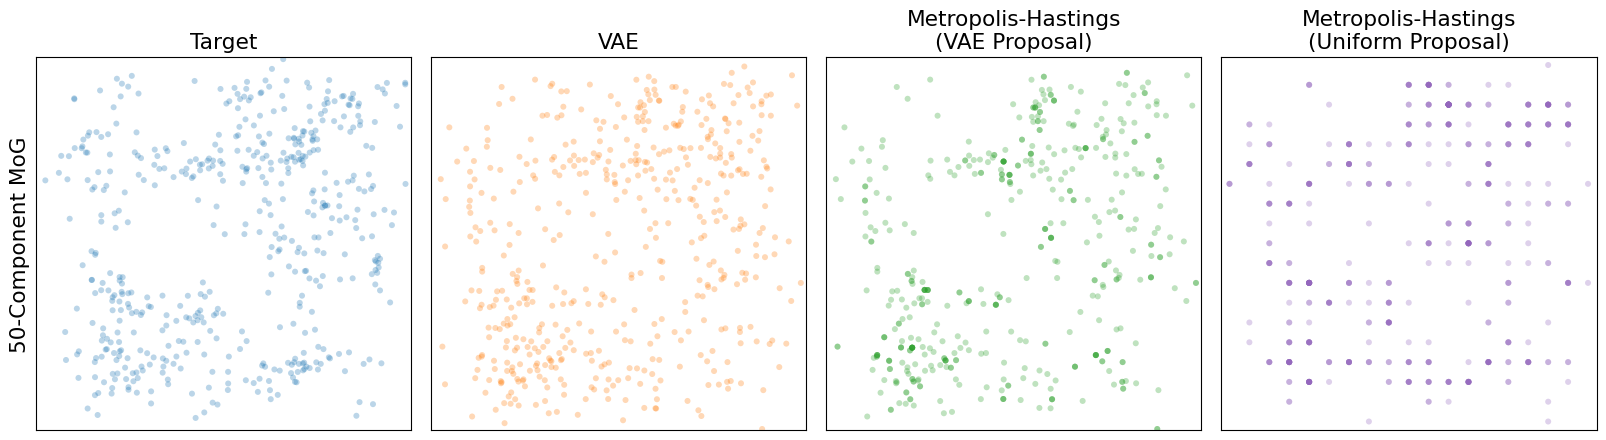

In [51]:
def plot_samples_paper_version():
    plt.rcParams.update({'font.size': 13})
    N = 500
    q = 0
    n_estimates = 10
    max_density_ratio = 7
    
    target_samples = target.sample((N,))
    target_quantile = target.log_prob(target_samples).quantile(q)
    model_samples = model.sample((N,))
    cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, model_samples, target_quantile, return_indicies=False)
    mh_acc_rate, mh_samples = metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator, n_estimates=n_estimates, max_density_ratio=max_density_ratio)

    proj_dims = (0, 1)
    clims = [(-0.2, 1.2), (-0.2, 1.2)]
    coord_values = [torch.linspace(*clim, ceil(N ** 0.5)) for clim in clims]
    grid_coords = torch.meshgrid(*coord_values, indexing='ij')
    uniform_samples = torch.vstack(tuple(map(torch.ravel, grid_coords))).T[torch.randperm(N)].to(device)
    uni_mh_acc_rate, uni_mh_samples = metropolis_hastings_filter(target, uniform_samples, dummy_estimator)
        
    plot_info = [
        (target_samples, 'Target', 'tab:blue'),
        (model_samples, 'VAE', 'tab:orange'),
        (mh_samples, 
         'Metropolis-Hastings\n(VAE Proposal)', 
         'tab:green'),
        (uni_mh_samples, 'Metropolis-Hastings\n(Uniform Proposal)', 'tab:purple')
    ]
    
    fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(16, 4.6))
    for i, (sample, sample_name, color) in tqdm(enumerate(plot_info)):
        axs[i].scatter(*pl(sample[:, proj_dims]), s=75, alpha=0.3, edgecolors='none', marker='.', c=color)
        axs[i].set_title(f'{sample_name}')
    for ax in axs:
        #ax.axis('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim((-0.1, 1.1))
        ax.set_ylim((-0.1, 1.1))
    plt.tight_layout()
    axs[0].set_ylabel(target_friendly_name, size='large')
    
plot_samples_paper_version()

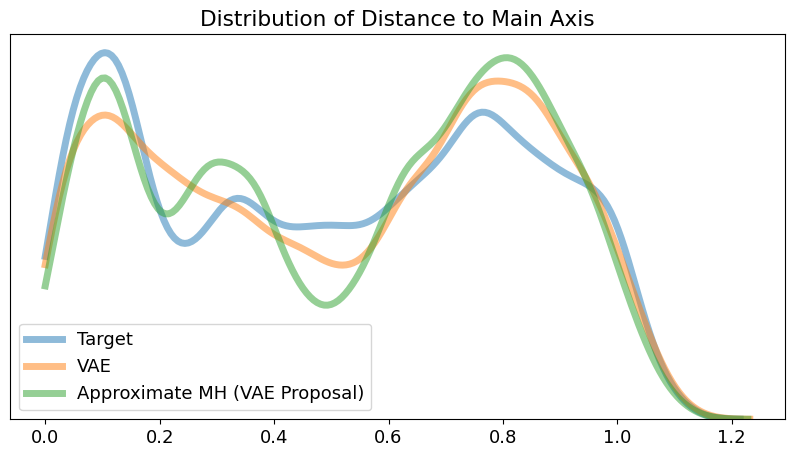

In [52]:
def analyze_feature_distribution():
    plt.rcParams.update({'font.size': 13})
    N = 1000
    q = 0
    n_estimates = 10
    feature = lambda x: torch.linalg.vector_norm(x[..., 1:], dim=-1)
    # feature = lambda x: x[..., 0]
    # feature = target.log_prob
    feature_name = 'Distance to Main Axis'
    
    target_samples = target.sample((N,))
    target_quantile = target.log_prob(target_samples).quantile(q)
    model_samples = model.sample((N,))
    cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, model_samples, target_quantile, return_indicies=False)
    
    mh_acc_rate, mh_samples = metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator, n_estimates=n_estimates)

    plot_info = [
        (target_samples, 'Target', 'tab:blue'),
        (model_samples, 'VAE', 'tab:orange'),
#        (cut_samples, 'VAE + Probability Cutoff', 'tab:red'),
        (mh_samples, 
         f'Approximate MH (VAE Proposal)', 
         'tab:green'),
    ]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    for sample, sample_name, sample_color in plot_info:
        sns.kdeplot(
            data=to_numpy(feature(sample)),
            alpha=0.5,
            label=sample_name,
            color=sample_color,
            linewidth=5,
#            bins=100,
#            binrange=(0, 60),
            bw_adjust=0.5,
            clip=(0, 60)
        )
    # ax.set_xlim(-10, 60)
    ax.legend()
    #ax.set_title(f'{target_friendly_name}\nDistributions of {feature_name}\n({N} samples)', y=1)
    ax.set_title(f'Distribution of {feature_name}', y=1)
    ax.get_yaxis().set_visible(False)

analyze_feature_distribution()

In [ ]:
def find_optimal_n_estimates():
    metric = SlicedDistributionMetric(WassersteinMetric1d(), 8)
    # metric = WassersteinMetric()
    N = 4000
    n_estimates_options = np.arange(1, 21)
    n_runs = 40
    q = 0.0
    target_samples = target.sample((N,))
    target_quantile = target.log_prob(target_samples).quantile(q)

    mh_metrics = []
    mh_acc_rates = []
    for n_estimates in tqdm(n_estimates_options):
        mh_metrics.append([])
        mh_acc_rates.append([])
        for i in range(n_runs):
            model_samples = model.sample((N,))
            cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, model_samples, target_quantile, return_indicies=False)
            mh_acc_rate, mh_samples = metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator, n_estimates=n_estimates)
            mh_metrics[-1].append(metric(target.sample((N,)), mh_samples).item())
            mh_acc_rates[-1].append(mh_acc_rate)

    def plot(ax_num, values, *args, **kwargs):
        values = np.array(values)
        values.sort()
        median_values = np.median(values, axis=-1)
        for i in range(values.shape[1]):
            axs[ax_num].plot(n_estimates_options, values[:, i], alpha=0.4, *args, **kwargs)
        axs[ax_num].plot(n_estimates_options, median_values, linewidth=3, *args, **kwargs)
    fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
    plot(0, mh_metrics, color='tab:green')
    # axs[0].set_title()
    axs[0].set_xlabel('# of Estimates')
    axs[0].set_ylabel(f'{metric.name()}')
    plot(1, mh_acc_rates, color='tab:orange')
    axs[1].set_xlabel('# of Estimates')
    axs[1].set_ylabel(f'Acceptance Rate')
    #plt.tight_layout()
    fig.suptitle(f'{target_friendly_name}\n Different Number of Estimate Evaluations in MH\n{N} Samples, {n_runs} Runs', y=1.03)

find_optimal_n_estimates()

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:44<00:00, 10.44s/it]


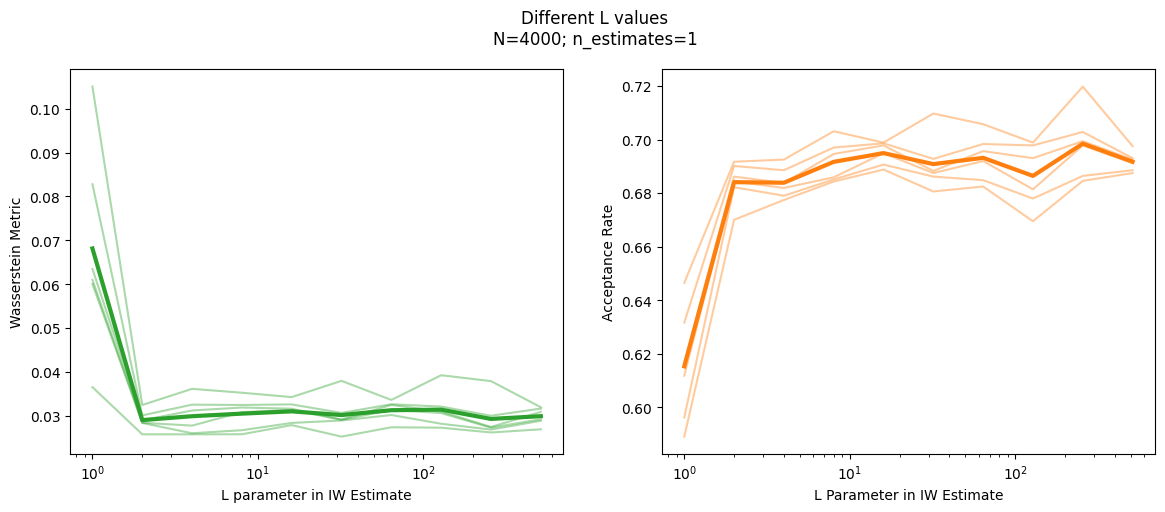

In [6]:
def find_optimal_L():
    # metric = SlicedDistributionMetric(WassersteinMetric1d(), 24)
    metric = WassersteinMetric()
    N = 4000
    q = 0.0
    L_options = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
    n_runs = 6
    n_estimates = 1
    
    target_samples = target.sample((N,))
    model_samples = model.sample((N,))
    target_quantile = target.log_prob(target_samples).quantile(q)
    cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, model_samples, target_quantile, return_indicies=False)

    mh_metrics = []
    mh_acc_rates = []
    for L in tqdm(L_options):
        mh_metrics.append([])
        mh_acc_rates.append([])
        model_log_prob_estimator = lambda x : model.iw_log_marginal_estimate(x, L=L, beta=beta, batch_L=32)
        for i in range(n_runs):
            mh_acc_rate, mh_samples = metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator, n_estimates=n_estimates)
            mh_metrics[-1].append(metric(target_samples, mh_samples).item())
            mh_acc_rates[-1].append(mh_acc_rate)

    def plot(ax_num, x, ys, *args, **kwargs):
        ys = np.array(ys)
        ys.sort()
        mean_ys = ys.mean(axis=-1)
        for i in range(ys.shape[1]):
            axs[ax_num].plot(x, ys[:, i], alpha=0.4, *args, **kwargs)
        axs[ax_num].plot(x, mean_ys, linewidth=3, *args, **kwargs)
    
    fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
    plot(0, L_options, mh_metrics, color='tab:green')
    # axs[0].set_title()
    axs[0].set_xlabel('L parameter in IW Estimate')
    axs[0].set_ylabel(f'{metric.name()}')
    plot(1, L_options, mh_acc_rates, color='tab:orange')
    axs[1].set_xlabel('L Parameter in IW Estimate')
    axs[1].set_ylabel(f'Acceptance Rate')
    for ax in axs:
        ax.set_xscale('log')
    #plt.tight_layout()
    fig.suptitle(f'Different L values\nN={N}; n_estimates={n_estimates}', y=1)

find_optimal_L()

  0%|                                                                                             | 0/4 [00:00<?, ?it/s]/home/doctor/venv/data/lib/python3.10/site-packages/ot/lp/solver_1d.py:41: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  cws = cws.T.contiguous()
 25%|█████████████████████▎                                                               | 1/4 [00:01<00:03,  1.28s/it]

MH discarded 0 outlier(s)


 50%|██████████████████████████████████████████▌                                          | 2/4 [00:02<00:02,  1.27s/it]

MH discarded 0 outlier(s)


 75%|███████████████████████████████████████████████████████████████▊                     | 3/4 [00:03<00:00,  1.02it/s]

MH discarded 0 outlier(s)


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]

MH discarded 0 outlier(s)


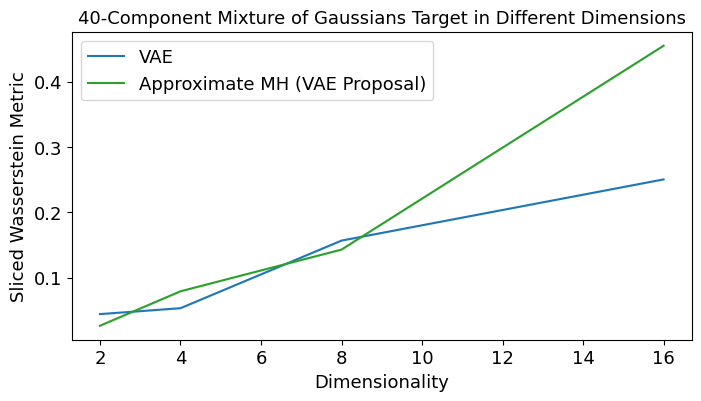

In [8]:
def plot_mog_scaling():
    plt.rcParams.update({'font.size': 13})
    
    # Target & model parameters
    mean_lim = np.array([0, 1])
    seed = 46
    n_components = 40
    variance_lim = (0.0005, 0.005)
    D_options = [2, 4, 8, 16]
    hidden_dims = (64, 64, 64, 64)
    N = 1000

    # Estimator parameters
    L = 512
    beta = 1
    
    # MH parameters
    q = 0
    n_estimates = 10
    max_density_ratio = 5.5

    # Evaluation
    n_runs = 1
    model_metrics = []
    cut_metrics = []
    mh_metrics = []

    for D in tqdm(D_options):
        target = create_random_gaussian_mixture(dim=D, n_components=n_components, mean_lim=mean_lim, variance_lim=variance_lim, device=device, seed=seed)
        target_name = f'mog{n_components}_{D}d_vlim{variance_lim}_seed{seed}'
        target_samples = target.sample((N,))
        target_quantile = target.log_prob(target_samples).quantile(q)
        
        model = VAE(
            data_dim=D,
            hidden_dims=hidden_dims,
            latent_dim=D,
            device=device
        )
        filename = Path(MODEL_DIR, f'{target_name}_hdim{hidden_dims}_vae')
        model.load_knowledge(filename)
        model.set_std_factor(1)
        model_log_prob_estimator = lambda x : model.iw_log_marginal_estimate(x, L=L, beta=beta, batch_L=32)
        
        metric = SlicedDistributionMetric(WassersteinMetric1d(), n_projections=2*D)
        cur_model_metrics = []
        cur_cut_metrics = []
        cur_mh_metrics = []
        for i in range(n_runs):
            model_samples = model.sample((N,))
            cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, model.sample((N,)), target_quantile, return_indicies=False)
            mh_acc_rate, mh_samples = metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator, n_estimates=n_estimates, max_density_ratio=max_density_ratio)
            target_samples = target.sample((N,))
            cur_model_metrics.append(metric(target_samples, model_samples).item())
            cur_cut_metrics.append(metric(target_samples, cut_samples).item())
            cur_mh_metrics.append(metric(target_samples, mh_samples).item())
        model_metrics.append(np.array(cur_model_metrics))
        cut_metrics.append(np.array(cur_cut_metrics))
        mh_metrics.append(np.array(cur_mh_metrics))

    plot_info = [
        ('VAE', model_metrics, 'tab:blue'),
#        ('VAE + Cutoff', cut_metrics, 'tab:red'),
        ('Approximate MH (VAE Proposal)', mh_metrics, 'tab:green')
    ]

    fig, ax = plt.subplots(figsize=(8, 4))
    for sample_name, metric_values, color in plot_info:
        metric_values = np.stack(metric_values)
        lower_quartiles, medians, upper_quartiles = np.quantile(metric_values, q=[0.25, 0.5, 0.75], axis=1)
        ax.plot(D_options, medians, color=color, label=sample_name)
        ax.fill_between(D_options, lower_quartiles, upper_quartiles, color=color, alpha=0.1)
    ax.legend()
    ax.set_xlabel('Dimensionality')
    ax.set_ylabel('Sliced Wasserstein Metric')
    ax.set_title(f'{n_components}-Component Mixture of Gaussians Target in Different Dimensions', fontsize=13)
    #ax.set_title(f'{n_components}-Component Mixture of Gaussians Target in Different Dimensions\n{N} Samples, {n_runs} Runs, 75% Confidence Intervals Shown')
        
        

plot_mog_scaling()